In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, recall_score, classification_report

In [5]:
train = pd.read_csv('../Data/train.csv')
X_train = train.copy().iloc[:, :-1]
y_train = train.copy()['stroke']

test = pd.read_csv('../Data/test.csv')
X_test = test.copy().iloc[:, :-1]
y_test = test.copy()['stroke']

In [6]:
print(f"Percentage of samples in training set that had a stroke: {round(np.mean(y_train)*100, 2)}%")
print(f"Percentage of samples in test set that had a stroke: {round(np.mean(y_test)*100, 2)}%")

Percentage of samples in training set that had a stroke: 4.88%
Percentage of samples in test set that had a stroke: 4.85%


# Preprocessing

In [7]:
X_train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,2.0,0,0,No,children,Rural,86.57,18.0,Unknown
1,Male,19.0,0,0,No,Private,Rural,79.60,36.7,Unknown
2,Male,11.0,0,0,No,children,Rural,68.62,18.2,Unknown
3,Female,80.0,0,0,Yes,Self-employed,Rural,90.43,34.2,never smoked
4,Female,51.0,0,0,Yes,Private,Urban,152.56,21.8,Unknown
...,...,...,...,...,...,...,...,...,...,...
3827,Female,50.0,0,0,No,Private,Urban,85.77,21.1,never smoked
3828,Female,5.0,0,0,No,children,Rural,59.61,17.1,Unknown
3829,Female,24.0,0,0,No,Private,Urban,149.17,23.1,never smoked
3830,Female,81.0,0,1,Yes,Private,Rural,123.49,30.7,smokes


In [16]:
class OutlierHandler(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, method='cap'):
        self.method = method
    
    def id_outlier_thresholds(self, X, y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (1.5*iqr))
        self.upper_bound.append(q3 + (1.5*iqr))
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.id_outlier_thresholds)
        return self
    
    def transform(self, X, y=None):
        X = pd.DataFrame(X).copy()
        if (self.method == 'cap'):
            for i in range(X.shape[1]):
                x = X.iloc[:, i].copy()
                x[x < self.lower_bound[i]] = self.lower_bound[i]
                x[x > self.upper_bound[i]] = self.upper_bound[i]
                X.iloc[:, i] = x
        return X


In [17]:
oh_encoder = ColumnTransformer(
            [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
              ['gender', 'work_type', 'Residence_type', 'smoking_status'])],
            remainder='passthrough')

bin_encoder = ColumnTransformer([('ordinal', OrdinalEncoder(), [-3])], remainder='passthrough')

imputer = KNNImputer(n_neighbors=3, weights='uniform')

outlier_handler = ColumnTransformer([('outliers', OutlierHandler(), [-2, -1])], remainder='passthrough')

scaler = ColumnTransformer([('scale', StandardScaler(), [-3, 0, 1])], remainder='passthrough')

transform = make_pipeline(oh_encoder, bin_encoder, imputer, outlier_handler, scaler, 'passthrough')
transform.fit(X_train)

col_names = [x.split("__")[-1] for x in transform.get_feature_names_out()]
X_train_transformed = pd.DataFrame(transform.transform(X_train), columns=col_names)

In [18]:
X_train_transformed

,age,avg_glucose_level,bmi,ever_married,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,-1.797776,-0.439780,-1.481642,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.049996,-0.648454,1.106448,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.401893,-0.977182,-1.453962,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.633212,-0.324217,0.760447,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.357588,1.535881,-0.955720,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,0.313601,-0.463731,-1.052600,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3828,-1.665815,-1.246931,-1.606202,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3829,-0.830061,1.434389,-0.775799,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3830,1.677199,0.665560,0.276045,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Note: If we do a GridSearch comparing the model with/without OutlierHandler, the Column indexes in scaler need to be changed

In [19]:
scaler2 = ColumnTransformer([('scale', StandardScaler(), [-5, -2, -1])], remainder='passthrough')
#                                                        ^^^^^^^^^^^^
transform2 = make_pipeline(oh_encoder, bin_encoder, imputer, scaler2, 'passthrough')
transform2.fit(X_train)

col_names = [x.split("__")[-1] for x in transform2.get_feature_names_out()]
X_train_transformed2 = pd.DataFrame(transform2.transform(X_train), columns=col_names)

In [20]:
X_train_transformed2

,age,avg_glucose_level,bmi,ever_married,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,-1.797776,-0.436349,-1.407985,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.049996,-0.590482,1.018674,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.401893,-0.833292,-1.382031,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.633212,-0.350990,0.694255,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.357588,1.022943,-0.914867,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,0.313601,-0.454040,-1.005704,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3828,-1.665815,-1.032538,-1.524776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3829,-0.830061,0.947977,-0.746169,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3830,1.677199,0.380094,0.240067,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Model Evaluation

In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=1, stratify=y_train)

In [28]:
def grid_search_heatmap(X, param_grid, multi_axis):
    results = pd.DataFrame(X)
    
    if multi_axis:
        fig, ax = plt.subplots(2, 2, figsize=(20,10), constrained_layout=True)

        param_scores = {'OutHanBal': {}, 'NoOutHanBal': {}, 'OutHan': {}, 'NoOutHan': {}}

        for param_val in param_grid['svc__C']:
            scores = results.loc[results['param_svc__C'] == param_val,
                                 ['param_svc__class_weight', 'param_scaler', 'mean_test_score']]
            out_han_bal_scores = list(scores.loc[(scores['param_svc__class_weight'] == 'balanced') &
                                                 (scores['param_scaler'].isna()), 'mean_test_score'])
            non_ohan_bal_scores = list(scores.loc[(scores['param_svc__class_weight'] == 'balanced') &
                                                  (scores['param_scaler'].notna()), 'mean_test_score'])
            out_han_scores = list(scores.loc[(scores['param_svc__class_weight'].isna()) &
                                             (scores['param_scaler'].isna()), 'mean_test_score'])
            non_ohan_scores = list(scores.loc[(scores['param_svc__class_weight'].isna()) &
                                              (scores['param_scaler'].notna()), 'mean_test_score'])
            param_scores['OutHanBal'][param_val] = out_han_bal_scores
            param_scores['NoOutHanBal'][param_val] = non_ohan_bal_scores
            param_scores['OutHan'][param_val] = out_han_scores
            param_scores['NoOutHan'][param_val] = non_ohan_scores

        out_han_bal_score_matrix = pd.DataFrame(param_scores['OutHanBal'], index=param_grid['svc__gamma'])
        out_han_bal_score_matrix = out_han_bal_score_matrix.rename_axis('Gamma')
        out_han_bal_score_matrix = out_han_bal_score_matrix.rename_axis('C', axis='columns')
        
        non_ohan_bal_score_matrix = pd.DataFrame(param_scores['NoOutHanBal'], index=param_grid['svc__gamma'])
        non_ohan_bal_score_matrix = non_ohan_bal_score_matrix.rename_axis('Gamma')
        non_ohan_bal_score_matrix = non_ohan_bal_score_matrix.rename_axis('C', axis='columns')
        
        out_han_score_matrix = pd.DataFrame(param_scores['OutHan'], index=param_grid['svc__gamma'])
        out_han_score_matrix = out_han_score_matrix.rename_axis('Gamma')
        out_han_score_matrix = out_han_score_matrix.rename_axis('C', axis='columns')

        non_ohan_score_matrix = pd.DataFrame(param_scores['NoOutHan'], index=param_grid['svc__gamma'])
        non_ohan_score_matrix = non_ohan_score_matrix.rename_axis('Gamma')
        non_ohan_score_matrix = non_ohan_score_matrix.rename_axis('C', axis='columns')

        sns.heatmap(out_han_score_matrix, ax=ax[0][0], cmap='viridis', annot=True)
        sns.heatmap(non_ohan_score_matrix, ax=ax[0][1], cmap='viridis', annot=True)
        sns.heatmap(out_han_bal_score_matrix, ax=ax[1][0], cmap='viridis', annot=True)
        sns.heatmap(non_ohan_bal_score_matrix, ax=ax[1][1], cmap='viridis', annot=True)

        ax[0][0].set_title('Outliers Handled')
        ax[0][1].set_title('No Outlier Handling')
        
        ax[0][0].set_ylabel('Unbalanced\nGamma')
        ax[1][0].set_ylabel('Balanced\nGamma')
    else:
        param_scores = {}

        for param_val in param_grid['svc__C']:
            scores = list(results.loc[results['param_svc__C'] == param_val, 'mean_test_score'])
            param_scores[param_val] = scores

        score_matrix = pd.DataFrame(param_scores, index=param_grid['svc__gamma'])
        score_matrix = score_matrix.rename_axis('Gamma')
        score_matrix = score_matrix.rename_axis('C', axis='columns')

        sns.heatmap(score_matrix, cmap='viridis', annot=True)

        plt.title('AUC Scores')


## Initial Grid Search

In [22]:
param_grid = [{'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__class_weight': [None, 'balanced']},
              {'outlier_handler': [None], 'scaler': [scaler2], 'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__class_weight': [None, 'balanced']}]
pipe = Pipeline([('oh_encoder', oh_encoder), ('bin_encoder', bin_encoder), ('imputer', imputer),
                 ('outlier_handler', outlier_handler), ('scaler', scaler), ('svc', SVC())])

grid_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('oh_encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['gender',
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status'])])),
                                       ('bin_encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         [-3])])...
                          'svc__class_weight': [None, 'balanced'],
                          'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
                         {'outlier_handler': [None],
                          'scaler': [ColumnTransformer(remainder='passthrough',
                                                       transformers=[('scale',
                                                                      StandardScaler(),
                                                                      [-5, -2,
                                                                       -1])])],
                          'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'svc__class_weight': [None, 'balanced'],
                          'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}],
             return_train_score=True, scoring='roc_auc')

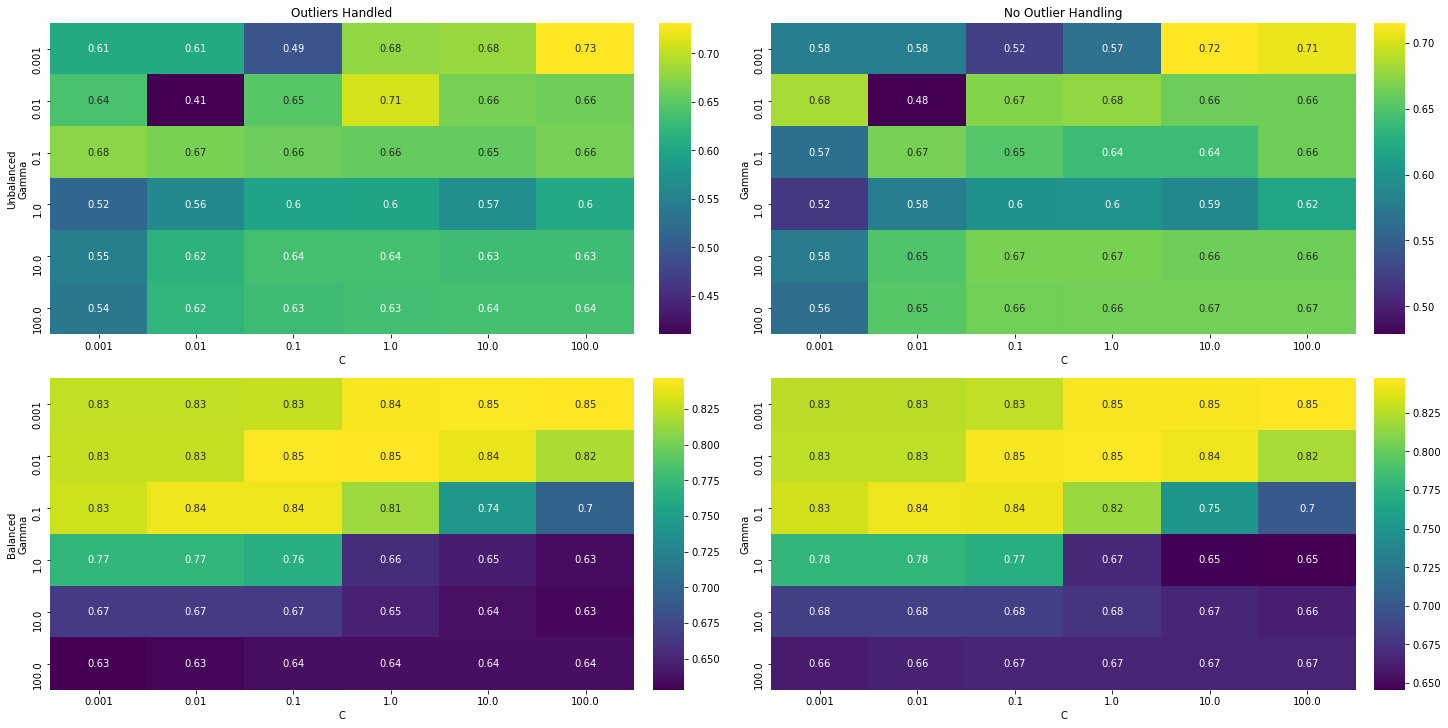

In [29]:
grid_search_heatmap(grid_search.cv_results_, param_grid[0], True)

In [30]:
print("Training\n--------------------")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}\n")

Training
--------------------
Best parameters: {'outlier_handler': None, 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(), [-5, -2, -1])]), 'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 0.001}
Best cross-validation score: 0.8473604208496995



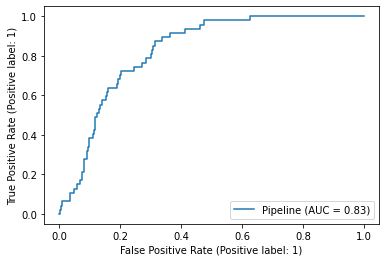

In [31]:
model = make_pipeline(oh_encoder, bin_encoder, imputer, grid_search.best_params_['scaler'],
                      SVC(C=grid_search.best_params_['svc__C'], gamma=grid_search.best_params_['svc__gamma'],
                          class_weight=grid_search.best_params_['svc__class_weight']))
model.fit(X_tr, y_tr)


RocCurveDisplay.from_estimator(model, X_val, y_val)

## Zoomed In Grid Search

In [32]:
param_grid_zoom = {'svc__C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                   'svc__gamma': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]}
pipe = Pipeline([('oh_encoder', oh_encoder), ('bin_encoder', bin_encoder), ('imputer', imputer),
                 ('scaler', scaler2), ('svc', SVC(class_weight='balanced'))])

grid_search_zoom = GridSearchCV(pipe, param_grid_zoom, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True)
grid_search_zoom.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('oh_encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['gender',
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status'])])),
                                       ('bin_encoder',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         [-3])])),
                                       ('imputer', KNNImputer(n_neighbors=3)),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         [-5,
                                                                          -2,
                                                                          -1])])),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'svc__gamma': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                        0.0006, 0.0007, 0.0008, 0.0009,
                                        0.001]},
             return_train_score=True, scoring='roc_auc')

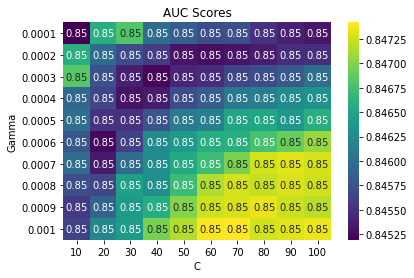

In [33]:
grid_search_heatmap(grid_search_zoom.cv_results_, param_grid_zoom, False)

In [34]:
print("Training\n--------------------")
print(f"Best parameters: {grid_search_zoom.best_params_}")
print(f"Best cross-validation score: {grid_search_zoom.best_score_}\n")

Training
--------------------
Best parameters: {'svc__C': 70, 'svc__gamma': 0.001}
Best cross-validation score: 0.8474214955696437



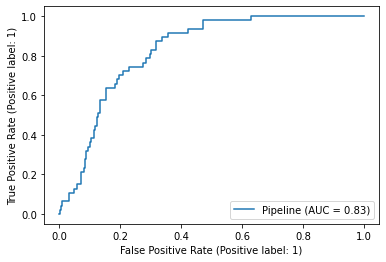

In [36]:
model_zoom = make_pipeline(oh_encoder, bin_encoder, imputer, scaler2,
                           SVC(C=grid_search_zoom.best_params_['svc__C'],
                               gamma=grid_search_zoom.best_params_['svc__gamma'],
                               class_weight='balanced'))
model_zoom.fit(X_tr, y_tr)


RocCurveDisplay.from_estimator(model_zoom, X_val, y_val)

In [37]:
fpr, tpr, thresholds = roc_curve(y_val, model.decision_function(X_val))

In [38]:
opt_thresh_1 = thresholds[np.argmax(tpr - fpr)]

print("Optimal Threshold (Youden's J)\n----------------------------------------")
print(f"Threshold: {opt_thresh_1}")
print(f"FPR & TPR at Optimal Threshold: ({fpr[np.argmax(tpr - fpr)]}, {tpr[np.argmax(tpr - fpr)]})")

Optimal Threshold (Youden's J)
----------------------------------------
Threshold: -0.17743498056659046
FPR & TPR at Optimal Threshold: (0.3150384193194292, 0.8723404255319149)


In [46]:
range_pos = (fpr > 0.4) & (fpr < 0.5)
opt_thresh_2 = thresholds[range_pos][np.argmax(tpr[range_pos])]

print("Optimal Threshold (Max TPR within acceptable range of FPR)\n------------------------------------------------------------")
print(f"Threshold: {opt_thresh_2}")
print(f"FPR & TPR at Optimal Threshold: ({fpr[range_pos][np.argmax(tpr[range_pos])]}, {tpr[range_pos][np.argmax(tpr[range_pos])]})")

Optimal Threshold (Max TPR within acceptable range of FPR)
------------------------------------------------------------
Threshold: -0.8947129186050686
FPR & TPR at Optimal Threshold: (0.47530186608122943, 0.9787234042553191)


# Results

In [40]:
print(f"AUC: {round(grid_search.score(X_test, y_test)*100, 2)}%")

AUC: 81.58%


Default Threshold
-------------------
Recall: 75.81%
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1216
           1       0.12      0.76      0.21        62

    accuracy                           0.73      1278
   macro avg       0.55      0.74      0.52      1278
weighted avg       0.94      0.73      0.81      1278



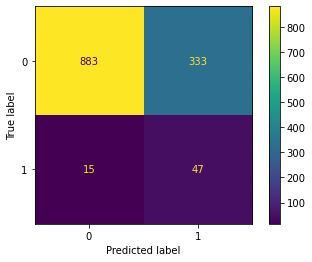

In [41]:
y_preds = grid_search.predict(X_test)
print("Default Threshold\n-------------------")
print(f"Recall: {round(recall_score(y_test, y_preds)*100, 2)}%")
print(classification_report(y_test, y_preds))
ConfusionMatrixDisplay.from_predictions(y_test, y_preds)

In [47]:
y_preds_1 = np.array(pd.Series(grid_search.decision_function(X_test) > opt_thresh_1).apply(lambda x: int(x)))
y_preds_2 = np.array(pd.Series(grid_search.decision_function(X_test) > opt_thresh_2).apply(lambda x: int(x)))

Threshold 1
-------------
Recall: 77.42%
              precision    recall  f1-score   support

           0       0.98      0.68      0.81      1216
           1       0.11      0.77      0.19        62

    accuracy                           0.69      1278
   macro avg       0.55      0.73      0.50      1278
weighted avg       0.94      0.69      0.78      1278



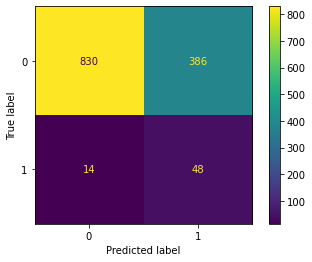

In [48]:
print("Threshold 1\n-------------")
print(f"Recall: {round(recall_score(y_test, y_preds_1)*100, 2)}%")
print(classification_report(y_test, y_preds_1))
ConfusionMatrixDisplay.from_predictions(y_test, y_preds_1)

Threshold 2
-------------
Recall: 88.71%
              precision    recall  f1-score   support

           0       0.99      0.50      0.67      1216
           1       0.08      0.89      0.15        62

    accuracy                           0.52      1278
   macro avg       0.54      0.70      0.41      1278
weighted avg       0.94      0.52      0.64      1278



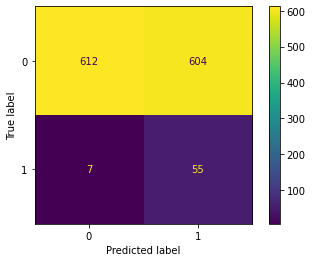

In [49]:
print("Threshold 2\n-------------")
print(f"Recall: {round(recall_score(y_test, y_preds_2)*100, 2)}%")
print(classification_report(y_test, y_preds_2))
ConfusionMatrixDisplay.from_predictions(y_test, y_preds_2)